In [9]:
import hyppo
import numpy as np
from numba import njit
from hyppo.independence.base import IndependenceTest
from hyppo._utils import perm_test
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import copy 
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree._classes import DecisionTreeClassifier
from joblib import Parallel, delayed
from scipy.stats import entropy, multivariate_normal
from scipy.integrate import nquad
from hyppo.sims import ksample_sim
from hyppo.ksample._utils import k_sample_transform
from tqdm import tqdm 

In [10]:
from statsmodels.distributions.empirical_distribution import ECDF
from hyppo.sims import *
from hyppo.ksample._utils import k_sample_transform

In [11]:
from benchmarks import power_2samp_sample
from hyppo.independence import CCA, Dcorr, HHG, Hsic, RV, MGC
from hyppo.sims import *

import sys
sys.executable
sys.path
#sys.path.append('C:\\Users\\siptest\\AppData\\Roaming\\Python\\Python36\\Scripts')
#sys.path.append('C:\\Users\\siptest\\Desktop\\R-3.6.2\\bin\\x64')

import sys, os
import multiprocessing as mp
from joblib import Parallel, delayed

import numpy as np
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns
sns.set(color_codes=True, style='white', context='talk', font_scale=2)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[3:])

In [12]:
def test_stat_helper(tree, tree_idx, X, y, sampled_indices, unsampled_indices, K, kappa = 3, base = 2): 
        # Randomly split the rest into voting and evaluation.
            
        total_unsampled = len(unsampled_indices)
        #np.random.shuffle(unsampled_indices)
        vote_indices = unsampled_indices[:total_unsampled//2]
        eval_indices = unsampled_indices[total_unsampled//2:]
            
        # Store the posterior in a num_nodes-by-num_classes matrix.
        # Posteriors in non-leaf cells will be zero everywhere
        # and later changed to uniform.
        node_counts = tree.tree_.n_node_samples
        class_counts = np.zeros((len(node_counts), K))
        est_nodes = tree.apply(X[vote_indices])
        est_classes = y[vote_indices]
        for i in range(len(est_nodes)):
            class_counts[est_nodes[i], est_classes[i]] += 1

        row_sums = class_counts.sum(axis=1) # Total number of estimation points in each leaf.
        row_sums[row_sums == 0] = 1 # Avoid divide by zero.
        class_probs = class_counts / row_sums[:, None]

        # Make the nodes that have no estimation indices uniform.
        # This includes non-leaf nodes, but tha t will not affect the estimate.
        class_probs[np.argwhere(class_probs.sum(axis = 1) == 0)] = [1 / K]*K
        # Apply finite sample correction and renormalize.
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1 / (kappa*class_counts.sum(axis = 1)[elem[0]])
        row_sums = class_probs.sum(axis=1)
        class_probs = class_probs / row_sums[:, None]

        # Place evaluation points in their corresponding leaf node.
        # Store evaluation posterior in a num_eval-by-num_class matrix.
        eval_class_probs = class_probs[tree.apply(X[eval_indices])]
        # eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_entropies = [entropy(posterior, base = base) for posterior in eval_class_probs]
        return np.mean(eval_entropies)
        #return cond_entropy
        
#def uf(self, X, y, n_estimators = 300, max_samples = .4, base = np.exp(1), kappa = 3):
def uf(X, y, n_estimators = 300, max_samples = .4, base = 2, kappa = 3):    
    # Build forest with default parameters.
    model = BaggingClassifier(DecisionTreeClassifier(), 
                              n_estimators=n_estimators, 
                              max_samples=max_samples, 
                              bootstrap=False)
    model.fit(X, y)
    n = X.shape[0]
    K = model.n_classes_
    _, y = np.unique(y, return_inverse=True)

    cond_entropy = 0
    final_null_dist = [0] * 100 

    for tree_idx, tree in enumerate(model):
        # Find the indices of the training set used for partition.
        sampled_indices = model.estimators_samples_[tree_idx]
        unsampled_indices = np.delete(np.arange(0,n), sampled_indices)
        np.random.shuffle(unsampled_indices)

        #return entropy([np.mean(y), 1 - np.mean(y)], base = 2) - cond_entropy / n_estimators
        cond_entropy += test_stat_helper(tree, tree_idx, X, y, sampled_indices, unsampled_indices, K)

        for j in range(100): 
            np.random.seed(j) # get same shuffle across
            null_unsampled_indices = unsampled_indices
            np.random.shuffle(null_unsampled_indices)
            final_null_dist[j] += test_stat_helper(tree, tree_idx, X, y, sampled_indices, null_unsampled_indices, K)
            
    new_final_null_dist = [entropy([np.mean(y), 1 - np.mean(y)], base = 2) - val / n_estimators for val in final_null_dist]

    final_stat = entropy([np.mean(y), 1 - np.mean(y)], base = 2) - cond_entropy / n_estimators
    return final_stat, new_final_null_dist


In [6]:
MAX_SAMPLE_SIZE = 100
STEP_SIZE = 20
SAMP_SIZES = range(10, MAX_SAMPLE_SIZE + STEP_SIZE, STEP_SIZE)
#POWER_REPS = 5
POWER_REPS = 20

SIMULATIONS = [
    #"linear": "Linear",
    #"multimodal_independence": "Independence"
    #linear, 
    multimodal_independence
]

#TESTS = [
    #UF, 
#]

In [13]:
def estimate_power(sim):
    
    power = []

    samp_size_dict = dict()
    for x in SAMP_SIZES: 
        pvalues = []
        num = 0
        numNull = 0
        stats = []
        null_dists = []
        for p in tqdm(range(POWER_REPS)): 
            print("Power Rep: " + str(p))
            matrix1, matrix2 = ksample_sim.trans_2samp(multimodal_independence, 100, 1, noise = True, trans = 0.3)

            x, y = k_sample_transform([matrix1, matrix2])
            stat, nullDist = uf(x, y)
            stats.append(stat)
            null_dists.append(nullDist)
            print("Test Stat: " + str(stat))
            pvalue = np.mean(np.asarray(nullDist) >= stat)
            print("P-value: " + str(pvalue))
            pvalues.append(pvalue)
        #samp_size_dict[x] = {'stats': stats, 'nullDists': null_dists}
        for pval in pvalues: 
            if pval <= 0.05: 
                num=num+1; 
        power.append(num / POWER_REPS) 
        #power.append((pvalues >= 0.05).sum() / POWER_REPS)
        
    #with open('honest_sampling_ind.pickle', 'wb') as handle: 
        #pickle.dump(samp_size_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    #with open('honest_sampling_ind.pickle', 'rb') as handle: 
        #b = pickle.load(handle)
    #print(samp_size_dict == b)

    np.savetxt('C:/Users/siptest/Desktop/hyppo/benchmarks/2samp_vs_samplesize/UF_HonestSampling_Ind.csv',
                   power, delimiter=',')
        
    
    return est_power

In [14]:
outputs = Parallel(n_jobs=-1, verbose=100)(
    [delayed(estimate_power)(sim) for sim in SIMULATIONS]
)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 163.3min


NameError: name 'est_power' is not defined

In [22]:
def plot_power2(): 
    
    sim_title = [
        #"Linear", 
        "Independence"
    ]
    sim = multimodal_independence
    power = np.genfromtxt('C:/Users/siptest/Desktop/hyppo/benchmarks/2samp_vs_samplesize/UF_HonestSampling_Ind.csv'.format(sim.__name__, "UF"),
                                      delimiter=',')
    plt.plot(power)
    plt.yticks([0, 1])
    plt.axhline(y=0.05, color='b', linestyle='--')
    positions = (0, 3, 5)
    labels = ("5", "65", "105")
    plt.xticks(positions, labels)
    plt.xlabel("Sample Size")
    plt.ylabel("Mean Power from 20 Reps")
    plt.savefig("C:/Users/siptest/Desktop/NDD/Independence_UF_HonestSampling.jpg", transparent=True, bbox_inches='tight')
    

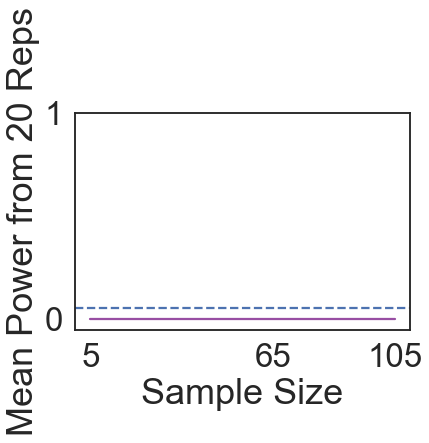

In [23]:
plot_power2()